<a href="https://colab.research.google.com/github/kuzhuppillil/Xwd9tHcXQqtfbaKV/blob/main/MonReader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [114]:
import os

import numpy as np
import random

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from tensorflow.keras import layers
from tensorflow.keras import Model
# from keras.models import Sequential
# from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
#from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras import backend as K
from tensorflow.keras.models import load_model

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

Defining directories containing the testing and training images. There are further 2 subdirectories in both training and testing directories containing flip and notflip images.

In [2]:
base_dir = '/content/drive/Othercomputers/My Laptop/Apziva Projects/MonReader/images'
train_dir = os.path.join(base_dir,'training')
valid_dir = os.path.join(base_dir,'validation')
test_dir = os.path.join(base_dir,'testing')

train_flip_dir = os.path.join(train_dir,'flip')
train_notflip_dir = os.path.join(train_dir,'notflip')

valid_flip_dir = os.path.join(valid_dir,'flip')
valid_notflip_dir = os.path.join(valid_dir,'notflip')

test_flip_dir = os.path.join(test_dir,'flip')
test_notflip_dir = os.path.join(test_dir,'notflip')

File naming conventions are same in both training and testing directories.

In [3]:
train_flip_fname = os.listdir(train_flip_dir)
train_flip_fname.sort()
print(train_flip_fname[:10])

train_notflip_fname = os.listdir(train_notflip_dir)
train_notflip_fname.sort()
print(train_notflip_fname[:10])

['0001_000000010.jpg', '0001_000000011.jpg', '0001_000000012.jpg', '0001_000000013.jpg', '0001_000000014.jpg', '0001_000000015.jpg', '0001_000000016.jpg', '0001_000000017.jpg', '0001_000000018.jpg', '0001_000000019.jpg']
['0001_000000001.jpg', '0001_000000003.jpg', '0001_000000005.jpg', '0001_000000006.jpg', '0001_000000007.jpg', '0001_000000008.jpg', '0001_000000010.jpg', '0001_000000011.jpg', '0001_000000012.jpg', '0001_000000013.jpg']


Checking the image count in all directories

In [4]:
print("Total training flip images:",len(os.listdir(train_flip_dir)))
print("Total training notflip images:",len(os.listdir(train_notflip_dir)))
print("Total validation flip images:",len(os.listdir(valid_flip_dir)))
print("Total validation notflip images:",len(os.listdir(valid_notflip_dir)))
print("Total testing flip images:",len(os.listdir(test_flip_dir)))
print("Total testing notflip images:",len(os.listdir(test_notflip_dir)))

Total training flip images: 1000
Total training notflip images: 1000
Total validation flip images: 162
Total validation notflip images: 230
Total testing flip images: 290
Total testing notflip images: 307


Displaying sample images from both directories to get a sense of the dataset.

In [5]:
# output image is configured 4x4
nrows = 2
ncols = 3

pic_index = 0


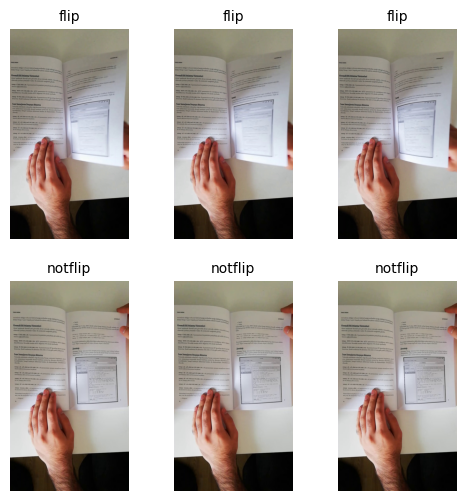

In [6]:
fig = plt.gcf()
fig.set_size_inches(ncols*2,nrows*3)

pic_index += 3
next_flip_pic = [os.path.join(train_flip_dir, fname) for fname in train_flip_fname[pic_index-3:pic_index]]
next_notflip_pic = [os.path.join(train_notflip_dir, fname) for fname in train_notflip_fname[pic_index-3:pic_index]]

for i, img_path in enumerate(next_flip_pic+next_notflip_pic):
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis("off")

  subdir_name = os.path.basename(os.path.dirname(img_path))
  plt.title(subdir_name, fontsize=10)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

# Data Preprocessing



*    The pixel values of the images are normalized, transforming the original range from (0-255) to a normalized range of (0-1).
* Data augmentation is applied to the training images as a strategy to mitigate overfitting. This involves introducing random transformations to each image during the training phase, enhancing the model's ability to generalize to various scenarios

In [103]:

# Creating the training generator
# all train images are augmented
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)



train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=30,
    class_mode='binary',
    classes=['notflip', 'flip']
)

# Creating the validation generator
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    valid_dir,
    target_size=(150, 150),
    batch_size=30,
    class_mode='binary',
    classes=['notflip', 'flip']
)



#Creating the test generator
test_datagen = ImageDataGenerator(rescale=1./255)


test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (150,150),
    batch_size=len(test_dir),
    class_mode= 'binary',
    classes=['notflip', 'flip']
)


Found 2000 images belonging to 2 classes.
Found 392 images belonging to 2 classes.
Found 597 images belonging to 2 classes.


In [ ]:
rain_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    train_data_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation') # set as validation data

model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // batch_size,
    epochs = nb_epochs)

In [75]:
# #function to convert RGB images to grayscale
# def rgb_to_grayscale(image):
#     # Convert the image to grayscale using the rgb2gray function from skimage
#     image = rgb2gray(image)
#     image = np.expand_dims(image, axis=-1)
#     return image


# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=40,
#     preprocessing_function=rgb_to_grayscale
# )

# train_generator = train_datagen.flow_from_directory(
#     train_dir,
#     target_size=(150, 150),
#     batch_size=20,
#     class_mode='binary',
#     classes=['notflip', 'flip'])

# validation_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=rgb_to_grayscale)

# validation_generator = validation_datagen.flow_from_directory(
#     valid_dir,
#     target_size=(150, 150),
#     batch_size=20,
#     class_mode='binary',
#     classes=['notflip', 'flip']
# )

# # Create the test data generator
# test_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=rgb_to_grayscale)

# test_generator = test_datagen.flow_from_directory(
#     test_dir,
#     target_size=(150, 150),
#     batch_size=20,
#     class_mode='binary',
#     classes=['notflip', 'flip']
# )

Found 2000 images belonging to 2 classes.
Found 392 images belonging to 2 classes.
Found 597 images belonging to 2 classes.


# Building CNN

*   All images are uniformly resized to 150x150 pixels and are in RGB format with three channels.
*   Our chosen model configuration is a widely adopted setup, especially suitable for small training datasets. It involves the stacking of three layers: convolution, rectified linear unit (ReLU) activation, and max-pooling. The convolutional layer employs a 3x3 filter, and the max-pooling layer uses a 2x2 filter.
* We utilize 16 filters for the first convolutional layer, followed by 32 filters in the second layer and 64 filters in the third layer
* To address overfitting, we introduce dropout, a technique that randomly deactivates some neurons during training to enhance model generalization.
* The final layers of the Convolutional Neural Network (CNN) consist of two fully-connected layers responsible for classification. The output layer employs a sigmoid activation function, ensuring that the output is a single scalar value ranging from 0 to 1.

In [87]:

img_input = layers.Input(shape=(150, 150, 3))

#1st convulution using 16 filters of 3x3 followed by max-pooling layer with 2x2 filter
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

#2nd convulution using 32 filters of 3x3 followed by max-pooling layer with 2x2 filter
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

#3rd convulution using 64 filters of 3x3 followed by max-pooling layer with 2x2 filter
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

#flattening feature map to 1D tensor
x = layers.Flatten()(x)

#Fully connected layer with ReLU activation and 256 hidden unit
x = layers.Dense(512, activation='relu')(x)

#Dropout rate of 0.5
x = layers.Dropout(0.5)(x)

#final output layer using sigmoid activation and single layer
output = layers.Dense(1, activation='sigmoid')(x)

model = Model(img_input, output)

model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 conv2d_30 (Conv2D)          (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 74, 74, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_31 (Conv2D)          (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_31 (MaxPooli  (None, 36, 36, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_32 (Conv2D)          (None, 34, 34, 64)        184

Configuring the model

In [88]:
# def f1_score(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#     predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

#     precision = true_positives / (predicted_positives + K.epsilon())
#     recall = true_positives / (possible_positives + K.epsilon())
#     return 2 * (precision * recall) / (precision + recall + K.epsilon())

model.compile(loss='binary_crossentropy',optimizer=RMSprop(learning_rate=0.001),metrics=['acc'])


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint('weight1.h5', monitor='val_loss', save_best_only=True)

# Training Model

In [89]:
#model retraining after adding data augmentation, dropout and reducing the hidden units

trained_data = model.fit(
    train_generator,
    steps_per_epoch = len(train_generator),
    epochs = 20,
    validation_data = validation_generator,
    validation_steps = len(validation_generator),
    callbacks=[early_stopping, checkpoint],
    verbose=2
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


67/67 - 118s - loss: 0.7167 - acc: 0.5460 - val_loss: 0.6383 - val_acc: 0.6786 - 118s/epoch - 2s/step
Epoch 2/20
67/67 - 103s - loss: 0.6693 - acc: 0.6030 - val_loss: 0.5848 - val_acc: 0.6913 - 103s/epoch - 2s/step
Epoch 3/20
67/67 - 107s - loss: 0.6175 - acc: 0.6750 - val_loss: 0.6914 - val_acc: 0.5357 - 107s/epoch - 2s/step
Epoch 4/20
67/67 - 105s - loss: 0.5737 - acc: 0.6985 - val_loss: 0.4768 - val_acc: 0.8316 - 105s/epoch - 2s/step
Epoch 5/20
67/67 - 120s - loss: 0.5415 - acc: 0.7435 - val_loss: 0.4137 - val_acc: 0.8597 - 120s/epoch - 2s/step
Epoch 6/20
67/67 - 105s - loss: 0.5005 - acc: 0.7700 - val_loss: 0.4949 - val_acc: 0.7423 - 105s/epoch - 2s/step
Epoch 7/20
67/67 - 112s - loss: 0.4355 - acc: 0.8050 - val_loss: 0.2968 - val_acc: 0.8801 - 112s/epoch - 2s/step
Epoch 8/20
67/67 - 105s - loss: 0.4151 - acc: 0.8095 - val_loss: 0.2900 - val_acc: 0.8673 - 105s/epoch - 2s/step
Epoch 9/20
67/67 - 116s - loss: 0.3640 - acc: 0.8535 - val_loss: 0.2893 - val_acc: 0.8750 - 116s/epoch - 2s

In [92]:
model.save_weights("/content/drive/Othercomputers/My Laptop/Apziva Projects/MonReader/model1_weights.h5")
model.save("/content/drive/Othercomputers/My Laptop/Apziva Projects/MonReader/model1")

# Visualizing the processing in each layer

1/1 [==============================] - 0s 143ms/step


<ipython-input-94-5116c34da674>:34: RuntimeWarning: invalid value encountered in divide
  x /= x.std()


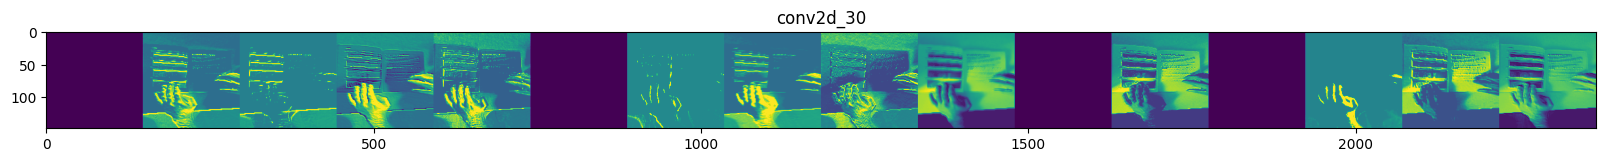

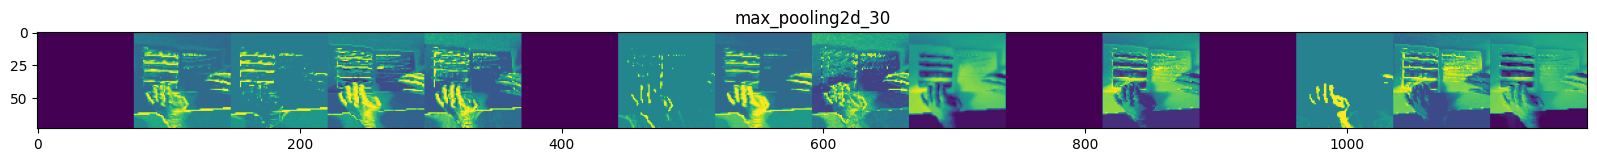

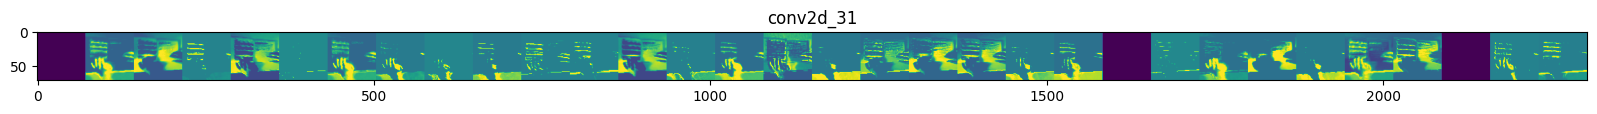

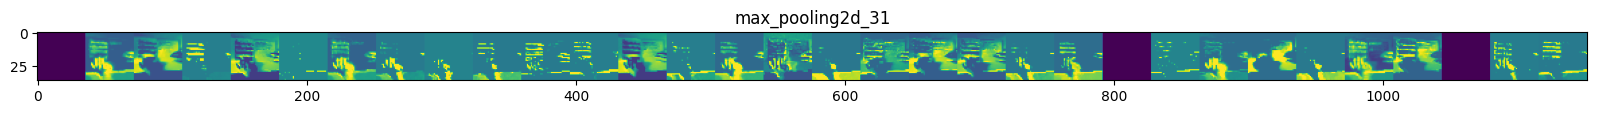

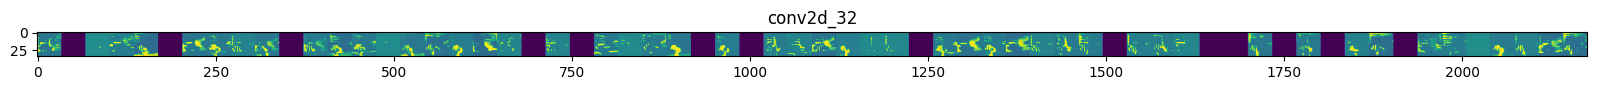

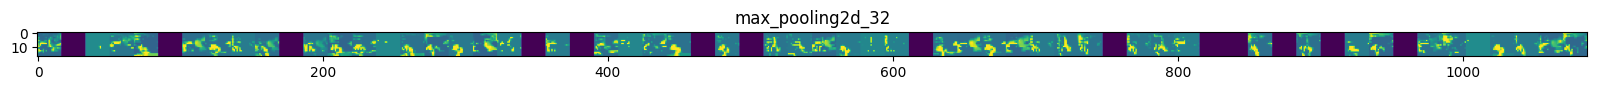

In [94]:
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = Model(img_input, successive_outputs)

#random input image
flip_img_files = [os.path.join(train_flip_dir, fname) for fname in train_flip_fname]
notflip_img_files = [os.path.join(train_notflip_dir, fname) for fname in train_notflip_fname]
img_path = random.choice(flip_img_files + notflip_img_files)

img = load_img(img_path, target_size=(150, 150))
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers[1:]]

for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

# Model Evaluation

In [95]:
def plot_eval(trained_data):
  acc = trained_data.history["acc"]
  val_acc = trained_data.history["val_acc"]

  loss = trained_data.history["loss"]
  val_loss = trained_data.history["val_loss"]

  epochs = range(len(acc))

  plt.plot(epochs, acc, label='Training Accuracy')
  plt.plot(epochs, val_acc, label='Validation Accuracy')
  plt.title("Training and Validation - Accuracy")
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy score')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, label='Training loss')
  plt.plot(epochs, val_loss, label='Validation loss')
  plt.title("Training and Validation - loss")
  plt.xlabel('Epochs')
  plt.ylabel('loss')
  plt.legend()

  plt.show()


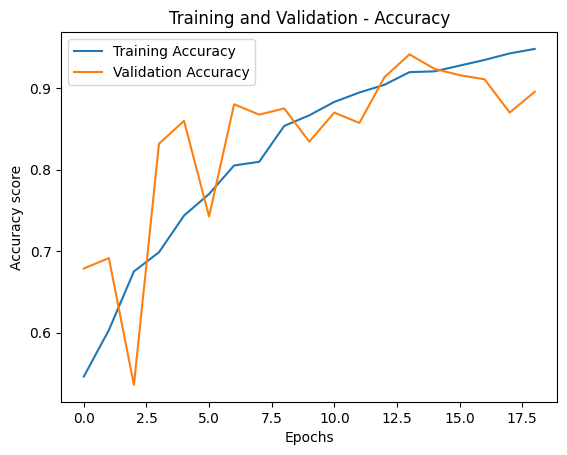

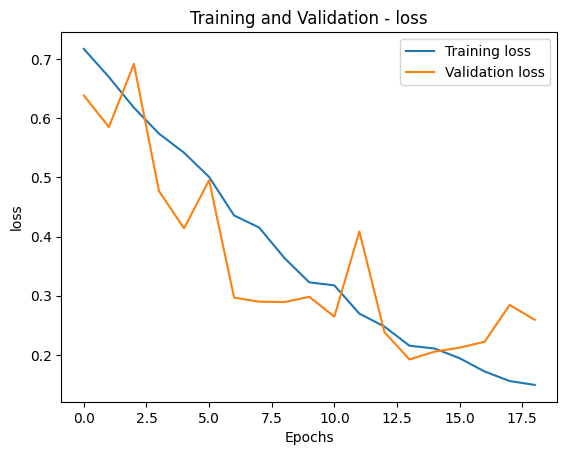

In [96]:
plot_eval(trained_data)

In [104]:
result = model.evaluate(test_generator)
print(f"Test Loss: {result[0]}")
print(f"Test accuracy: {result[1]}")

8/8 [==============================] - 13s 2s/step - loss: 0.1726 - acc: 0.9229
Test Loss: 0.17260383069515228
Test accuracy: 0.9229480624198914


In [113]:
y_true = []
y_pred = []

for i in range(len(test_generator)):
    x, y = next(test_generator)
    y_true.extend(y)
    preds = model.predict(x)
    y_pred.extend(preds.squeeze())

y_true = np.array(y_true)
y_pred = (np.array(y_pred) >= 0.5).astype(int)

class_names = ['notflip', 'flip']

print(classification_report(y_true, y_pred, target_names=class_names))

3/3 [==============================] - 0s 137ms/step
              precision    recall  f1-score   support

     notflip       0.96      0.87      0.92       300
        flip       0.88      0.97      0.92       297

    accuracy                           0.92       597
   macro avg       0.92      0.92      0.92       597
weighted avg       0.92      0.92      0.92       597



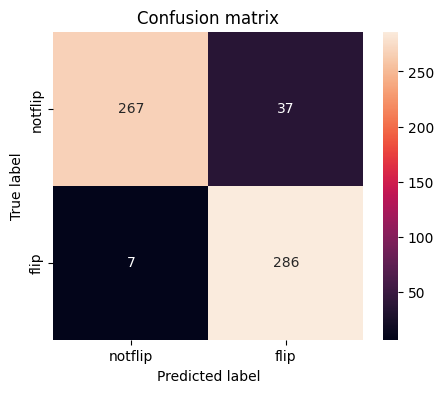

In [111]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, xticklabels=class_names, yticklabels=class_names, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Observation:



1.   Among the set of 300 "notflip" images, 37 were incorrectly classified.
2.   7 out of 286 'flip' images were misclassified.



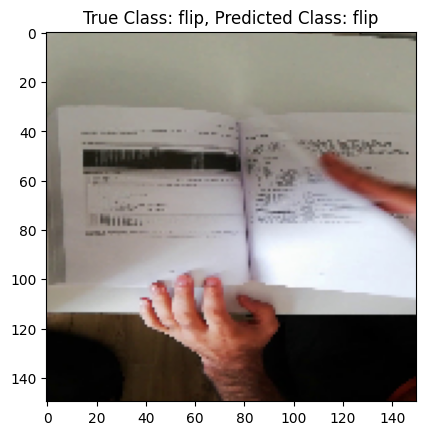

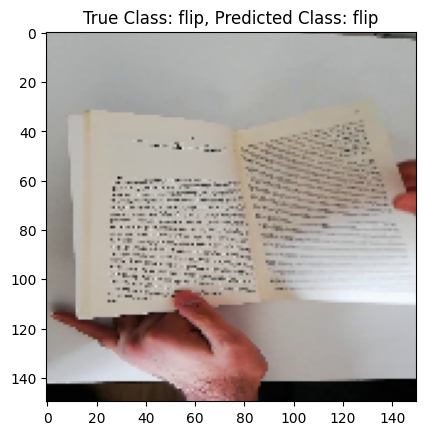

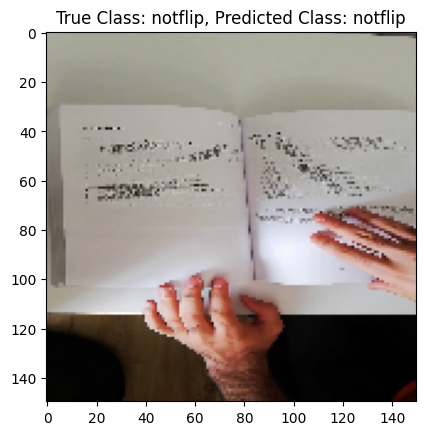

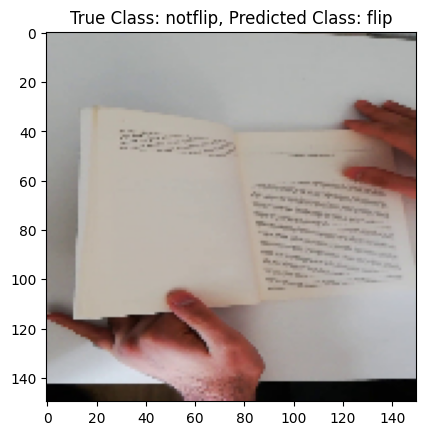

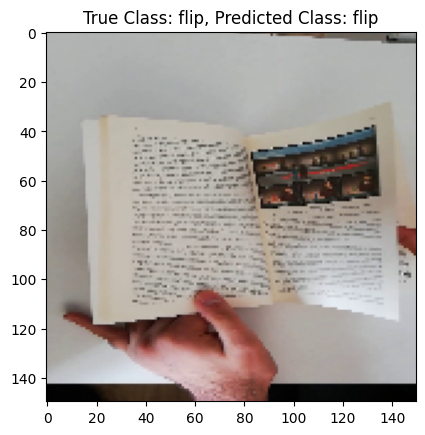

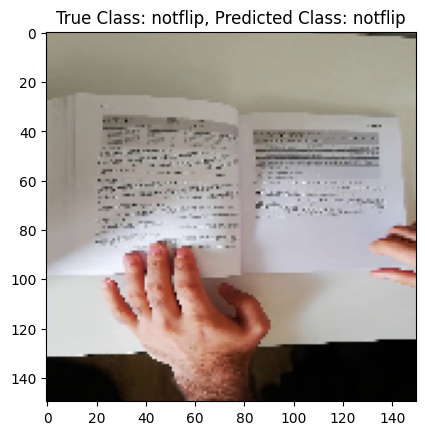

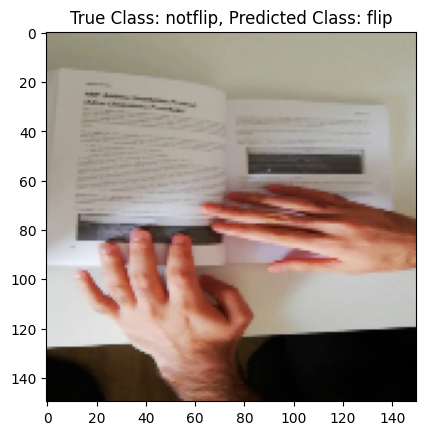

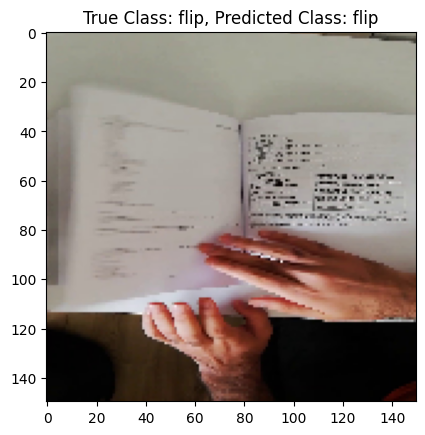

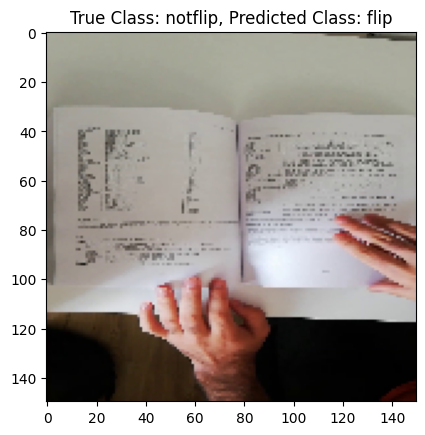

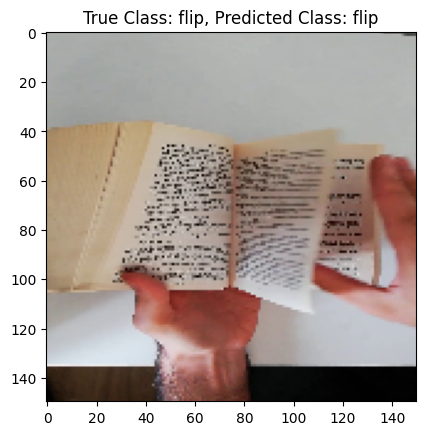

In [115]:
x, y = next(test_generator)
images = x
labels = y

indices = np.random.choice(len(images), size=10, replace=False)
for idx in indices:
    true_class = class_names[int(labels[idx])]
    pred_class = class_names[int(y_pred[idx])]

    plt.imshow(images[idx])
    plt.title(f"True Class: {true_class}, Predicted Class: {pred_class}")
    plt.show()

# **Observation:**



## 1.   We have successfully constructed a convolutional neural network (CNN) model for image classification, achieving an impressive F1 score of 92%.
## 2.    To mitigate overfitting, we implemented data preprocessing - data augmentation and dropout
## 3. Examining the image sequence classification results above, only 3 out of 10 instances were misclassified, demonstrating the robustness of our model.





# **References:**
1.   http://colah.github.io/posts/2014-03-NN-Manifolds-Topology/
2. https://keras.io/api/data_loading/image/
3.   https://en.wikipedia.org/wiki/Stochastic_gradient_descent#RMSProp
4.   https://developers.google.com/machine-learning/practica/image-classification
5. https://towardsdatascience.com/understanding-rmsprop-faster-neural-network-learning-62e116fcf29a.  
